In [500]:
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.DEBUG)

%pylab inline
import nltk
import datetime
import matplotlib.pyplot as plt
import time
import numpy as np
import pandas as pd
import os
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from gensim.models import Word2Vec,WordEmbeddingSimilarityIndex
from gensim.models import Phrases
from gensim.corpora import Dictionary
from gensim.models import TfidfModel
from gensim.similarities import Similarity,MatrixSimilarity
from gensim.similarities import SoftCosineSimilarity, SparseTermSimilarityMatrix
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

2020-04-22 18:33:10,512 : DEBUG : Loaded backend module://ipykernel.pylab.backend_inline version unknown.


Populating the interactive namespace from numpy and matplotlib


### create csv

In [3]:
path = "/Users/john/Desktop/school/csce_474/final project/hrv_articles"
files = os.listdir(path)
raw_text_l = []
title_l = []
text_id_l = []
for file in files: 
    if not os.path.isdir(file):
        text_id_l.append(file[:-4])
        f = open(path+"/"+file)
        title = f.readline()
        title_l.append(title[:-1])
        f = open(path+"/"+file)
        raw_text = f.read()
        raw_text_l.append(raw_text)

In [4]:
data = pd.DataFrame({'id':text_id_l,'title':title_l,'raw_text':raw_text_l})

In [5]:
data.to_csv("HRV_big.csv",index=False,sep=',')

### read csv

In [67]:
df = pd.read_csv('HRV_big.csv')

In [526]:
df.head()

,id,title,raw_text
0,15082602301,Army Mobilized around Nepal Town Hit by Deadly...,Army Mobilized around Nepal Town Hit by Deadly...
1,16101001201,AAP Legislator Named in Clash FIR,AAP Legislator Named in Clash FIR\n\nNew Delhi...
2,16051603801,Cash for Votes: TN Opposition Parties Pull Up ...,Cash for Votes: TN Opposition Parties Pull Up ...
3,16083007101,'Criminalising Marital Rape Complicated','Criminalising Marital Rape Complicated'\n\nNe...
4,16100112801,Jharkhand: 4 Villagers Killed in Police Firing...,Jharkhand: 4 Villagers Killed in Police Firing...


### tokenization & lemmatization

In [69]:
def docs_preprocessor(docs):
    tokenizer = RegexpTokenizer(r'\w+')
    for i in range(len(docs)):
        docs[i] = docs[i].split("… \n\nArticle")[0]
        docs[i] = docs[i].replace("\n"," ")
        docs[i] = docs[i].replace("--"," ")
        docs[i] = docs[i].lower()
        # tokenization
        docs[i] = tokenizer.tokenize(docs[i])
    
    docs = [[token for token in doc if (len(token) > 3 or token.isdigit())] for doc in docs]
    #lemmatization
    lemmatizer = WordNetLemmatizer()
    docs = [[lemmatizer.lemmatize(token) for token in doc] for doc in docs]
    
    return docs
    

In [70]:
docs_array = np.array(df['raw_text'])
docs_array.shape

(561,)

In [71]:
%time docs = docs_preprocessor(docs_array)
len(docs)

CPU times: user 265 ms, sys: 45.4 ms, total: 310 ms
Wall time: 309 ms


561

### generate bigrams & trigrams

In [72]:
bigram = Phrases(docs, min_count=1,threshold=1)

2020-04-21 19:59:39,820 : INFO : collecting all words and their counts
2020-04-21 19:59:39,821 : INFO : PROGRESS: at sentence #0, processed 0 words and 0 word types
2020-04-21 19:59:39,917 : INFO : collected 39047 word types from a corpus of 49265 words (unigram + bigrams) and 561 sentences
2020-04-21 19:59:39,917 : INFO : using 39047 counts as vocab in Phrases<0 vocab, min_count=1, threshold=1, max_vocab_size=40000000>


In [73]:
trigram = Phrases(bigram[docs], min_count=1,threshold=1)

2020-04-21 19:59:40,563 : INFO : collecting all words and their counts
2020-04-21 19:59:40,565 : INFO : PROGRESS: at sentence #0, processed 0 words and 0 word types
2020-04-21 19:59:40,805 : INFO : collected 42816 word types from a corpus of 34962 words (unigram + bigrams) and 561 sentences
2020-04-21 19:59:40,806 : INFO : using 42816 counts as vocab in Phrases<0 vocab, min_count=1, threshold=1, max_vocab_size=40000000>


In [74]:
for i in range(len(docs)):
    for token in bigram[docs[i]]:
        if '_' in token:
            # Token is a bigram, add to document.
            docs[i].append(token)
    for token in trigram[docs[i]]:
        if '_' in token:
            # Token is a bigram, add to document.
            docs[i].append(token)

### remove rare and common tokens

In [75]:
dictionary = Dictionary(docs)
print("before filtering",len(dictionary))
dictionary.filter_extremes(no_below=2,no_above=0.4)
print("after filtering",len(dictionary))

#for k, v in dictionary.token2id.items():
    #print(k, v)

2020-04-21 19:59:43,286 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2020-04-21 19:59:43,398 : INFO : built Dictionary(13447 unique tokens: ['2', '26', 'after', 'after_declaring', 'after_police']...) from 561 documents (total 86675 corpus positions)
2020-04-21 19:59:43,418 : INFO : discarding 4825 tokens: [('after', 253), ('police', 424), ('were', 249), ('western', 1), ('with', 264), ('accused_supporter', 1), ('against', 242), ('conducted_after', 1), ('cross_registered', 1), ('crossfir', 1)]...
2020-04-21 19:59:43,419 : INFO : keeping 8622 tokens which were in no less than 2 and no more than 224 (=40.0%) documents
2020-04-21 19:59:43,424 : DEBUG : rebuilding dictionary, shrinking gaps
2020-04-21 19:59:43,429 : INFO : resulting dictionary: Dictionary(8622 unique tokens: ['2', '26', 'after_declaring', 'after_police', 'after_police_fired_tear']...)


before filtering 13447
after filtering 8622


### BOW representation of data

In [76]:
corpus = [dictionary.doc2bow(doc) for doc in docs]
print('Number of unique tokens: %d' % len(dictionary))
print('Number of documents: %d' % len(corpus))

Number of unique tokens: 8622
Number of documents: 561


# TF-IDF

In [77]:
model_tfidf = TfidfModel(corpus)

2020-04-21 19:59:46,707 : INFO : collecting document frequencies
2020-04-21 19:59:46,708 : INFO : PROGRESS: processing document #0
2020-04-21 19:59:46,720 : INFO : calculating IDF weights for 561 documents and 8622 features (46906 matrix non-zeros)


In [78]:
corpus_tfidf = model_tfidf[corpus]

In [79]:
# cosine similarity matrix
index = MatrixSimilarity(corpus_tfidf)
similarity_matrix = index[corpus_tfidf]

2020-04-21 19:59:48,171 : WARNING : scanning corpus to determine the number of features (consider setting `num_features` explicitly)
2020-04-21 19:59:48,419 : INFO : creating matrix with 561 documents and 8622 features
2020-04-21 19:59:48,420 : DEBUG : PROGRESS: at document #0/561


In [80]:
similarity_matrix

array([[9.9999940e-01, 1.7578745e-03, 1.9011308e-03, ..., 2.7902112e-03,
        2.4531837e-04, 1.5320969e-02],
       [1.7578745e-03, 9.9999994e-01, 7.0095696e-03, ..., 4.6745283e-04,
        1.6460050e-03, 4.2065331e-03],
       [1.9011308e-03, 7.0095696e-03, 9.9999976e-01, ..., 5.5643301e-03,
        1.7014717e-03, 2.9027427e-04],
       ...,
       [2.7902112e-03, 4.6745283e-04, 5.5643301e-03, ..., 1.0000000e+00,
        3.4023959e-02, 2.8729062e-03],
       [2.4531837e-04, 1.6460050e-03, 1.7014717e-03, ..., 3.4023959e-02,
        9.9999994e-01, 3.2697895e-03],
       [1.5320969e-02, 4.2065331e-03, 2.9027427e-04, ..., 2.8729062e-03,
        3.2697895e-03, 1.0000002e+00]], dtype=float32)

### near-duplication detection (clustering based on similarity threshold)

In [528]:
def trans_similarity_matrix2dic(sims):
    sims_dic = []
    for i in range(len(sims)):
        dic = {}
        for j in range(len(sims[i])):
            dic[j] = sims[i][j]
        sims_dic.append(dic)
        
    return sims_dic

def get_same_events_dic(sims_dic):
    same_events_dic = []
    for i in range(len(sims_dic)):
        same_event_dic = {}
        for k,v in sims_dic[i].items():
            if v >= 0.6:       # similarity threshold
                same_event_dic[k] = v
        same_events_dic.append(same_event_dic)
    
    return same_events_dic
    
    
def get_same_events(same_events_dic):
    same_events_list = []
    for dic in same_events_dic:
        same_events_list.append(list(dic.keys()))
    same_events_temp = list(np.unique(same_events_list))
    pool = set(map(frozenset, same_events_temp))
    same_events = []
    while pool:
        same_events.append(set(pool.pop()))
        while True:
            for candidate in pool:
                if same_events[-1] & candidate:
                    same_events[-1] |= candidate
                    pool.remove(candidate)
                    break
            else:
                break
    same_events = sorted([sorted(list(event)) for event in same_events])
    
    return same_events

def get_same_events_with_id(same_events):
    same_events_with_id = []
    for i in range(len(same_events)):
        same_events_with_id.append([])
        for j in range(len(same_events[i])):
            same_events_with_id[i].append(df.iloc[same_events[i][j]]['id'])
    
    return same_events_with_id 
      

In [529]:
similarity_matrix_dic = trans_similarity_matrix2dic(similarity_matrix)

In [530]:
same_events_dic = get_same_events_dic(similarity_matrix_dic)

In [531]:
same_events = get_same_events(same_events_dic)

In [539]:
same_events

[[0, 184],
 [1],
 [2],
 [3, 155],
 [4],
 [5],
 [6, 152],
 [7],
 [8],
 [9, 183],
 [10],
 [11],
 [12, 177],
 [13],
 [14],
 [15],
 [16],
 [17],
 [18],
 [19, 438],
 [20],
 [21],
 [22],
 [23, 133, 217],
 [24],
 [25],
 [26],
 [27],
 [28],
 [29],
 [30],
 [31],
 [32],
 [33],
 [34],
 [35],
 [36],
 [37],
 [38, 371, 554],
 [39],
 [40],
 [41],
 [42],
 [43],
 [44],
 [45, 153],
 [46],
 [47],
 [48],
 [49],
 [50],
 [51],
 [52],
 [53],
 [54],
 [55, 292, 341, 465],
 [56],
 [57],
 [58, 70],
 [59],
 [60],
 [61],
 [62, 262],
 [63],
 [64],
 [65],
 [66],
 [67],
 [68],
 [69, 524],
 [71],
 [72],
 [73],
 [74],
 [75],
 [76, 532],
 [77],
 [78],
 [79],
 [80],
 [81],
 [82],
 [83],
 [84],
 [85],
 [86],
 [87, 124],
 [88],
 [89],
 [90],
 [91, 222],
 [92],
 [93],
 [94],
 [95, 461],
 [96],
 [97],
 [98],
 [99],
 [100],
 [101],
 [102],
 [103, 249],
 [104],
 [105],
 [106],
 [107],
 [108, 258],
 [109, 220],
 [110],
 [111],
 [112],
 [113],
 [114],
 [115],
 [116],
 [117],
 [118, 312],
 [119],
 [120],
 [121],
 [122],
 [123],
 

In [533]:
same_events_with_id = get_same_events_with_id(same_events)

In [538]:
len(same_events_with_id)

498

In [543]:
df['raw_text'][0]

"Army Mobilized around Nepal Town Hit by Deadly Protests\n\nKathmandu, Aug. 26 -- Army has been mobilized in areas surrounding Nepal's Tikapur town on Tuesday, a day after violent clashes between protesters and security forces claimed eight lives.Kailali district authorities took the decision after declaring nine village development committees (VDCs) and one municipality as riot zones.Eight persons including seven policemen and a 2-year-old were killed when thousands of protesters armed with sickles, axes, spears and knives attacked a police picket in Tikapur in far-western Nepal.The incident took place after police fired tear gas shells and several rounds in air to disperse the mob which had broken prohibitory orders. The protesters were demanding a separate state for the marginalized Tharu community. … \n\nArticle ID: 15082602301"

In [544]:
df['raw_text'][184]

'Army Mobilised around Nepal Town\n\nKathmandu, Aug. 26 -- Nepal has mobilized its army in areas surrounding Tikapur town on Tuesday, a day after violent clashes between protesters and security forces claimed eight lives.Kailali district authorities took the decision after declaring nine village development committees (VDCs) and one municipality as riot zones.Eight persons including seven policemen and a two-year-old were killed when thousands of protesters armed with sickles, axes, spears and knives attacked a police picket in Tikapur in farwestern Nepal.The incident took place after police fired tear gas shells and several rounds in air to disperse the mob which had broken prohibitory orders. The protesters were demanding a separate state for the marginalized Tharu community. … \n\nArticle ID: 15082602201'

### calculate the duplicate rate

In [542]:
(len(docs) - len(same_events_with_id))/len(docs)

0.11229946524064172

# Word2vec

In [50]:
# set training parameters
size = 300       # dimension of the word vector
window_size = 2  # maximum distance between the current and predicted word within a sentence
epochs = 100     # number of iterations (epochs) over the corpus
min_count = 2    # ignores all words with total frequency lower than this
workers = 4      # use these many worker threads to train the model

### model training

In [112]:
%time model_word2vec = Word2Vec(docs, sg=1,window=window_size,size=size, min_count=min_count,workers=workers,iter=epochs,sample=0.01)

2020-04-21 20:40:08,911 : INFO : collecting all words and their counts
2020-04-21 20:40:08,913 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2020-04-21 20:40:08,931 : INFO : collected 13447 word types from a corpus of 86675 raw words and 561 sentences
2020-04-21 20:40:08,931 : INFO : Loading a fresh vocabulary
2020-04-21 20:40:08,953 : INFO : effective_min_count=2 retains 10804 unique words (80% of original 13447, drops 2643)
2020-04-21 20:40:08,954 : INFO : effective_min_count=2 leaves 84032 word corpus (96% of original 86675, drops 2643)
2020-04-21 20:40:08,987 : INFO : deleting the raw counts dictionary of 13447 items
2020-04-21 20:40:08,988 : INFO : sample=0.01 downsamples 0 most-common words
2020-04-21 20:40:08,989 : INFO : downsampling leaves estimated 84032 word corpus (100.0% of prior 84032)
2020-04-21 20:40:09,012 : INFO : estimated required memory for 10804 words and 300 dimensions: 31331600 bytes
2020-04-21 20:40:09,013 : INFO : resetting layer w

2020-04-21 20:40:13,249 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-04-21 20:40:13,270 : DEBUG : worker exiting, processed 3 jobs
2020-04-21 20:40:13,271 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-04-21 20:40:13,272 : INFO : EPOCH - 9 : training on 86675 raw words (84032 effective words) took 0.2s, 402400 effective words/s
2020-04-21 20:40:13,354 : DEBUG : job loop exiting, total 9 jobs
2020-04-21 20:40:13,458 : DEBUG : worker exiting, processed 2 jobs
2020-04-21 20:40:13,458 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-04-21 20:40:13,464 : DEBUG : worker exiting, processed 2 jobs
2020-04-21 20:40:13,464 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-04-21 20:40:13,473 : DEBUG : worker exiting, processed 2 jobs
2020-04-21 20:40:13,473 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-04-21 20:40:13,506 : DEBUG : worker exiting, processed 3 jobs
2020-04-21 2

2020-04-21 20:40:15,155 : DEBUG : worker exiting, processed 2 jobs
2020-04-21 20:40:15,155 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-04-21 20:40:15,182 : DEBUG : worker exiting, processed 3 jobs
2020-04-21 20:40:15,183 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-04-21 20:40:15,184 : INFO : EPOCH - 19 : training on 86675 raw words (84032 effective words) took 0.2s, 442278 effective words/s
2020-04-21 20:40:15,256 : DEBUG : job loop exiting, total 9 jobs
2020-04-21 20:40:15,335 : DEBUG : worker exiting, processed 2 jobs
2020-04-21 20:40:15,335 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-04-21 20:40:15,341 : DEBUG : worker exiting, processed 2 jobs
2020-04-21 20:40:15,341 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-04-21 20:40:15,349 : DEBUG : worker exiting, processed 2 jobs
2020-04-21 20:40:15,350 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-04-21 

2020-04-21 20:40:16,995 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-04-21 20:40:16,998 : DEBUG : worker exiting, processed 2 jobs
2020-04-21 20:40:16,998 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-04-21 20:40:17,020 : DEBUG : worker exiting, processed 3 jobs
2020-04-21 20:40:17,020 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-04-21 20:40:17,022 : INFO : EPOCH - 29 : training on 86675 raw words (84032 effective words) took 0.2s, 460681 effective words/s
2020-04-21 20:40:17,098 : DEBUG : job loop exiting, total 9 jobs
2020-04-21 20:40:17,174 : DEBUG : worker exiting, processed 2 jobs
2020-04-21 20:40:17,174 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-04-21 20:40:17,178 : DEBUG : worker exiting, processed 2 jobs
2020-04-21 20:40:17,178 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-04-21 20:40:17,183 : DEBUG : worker exiting, processed 2 jobs
2020-04-21 

2020-04-21 20:40:18,853 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-04-21 20:40:18,857 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-04-21 20:40:18,858 : DEBUG : worker exiting, processed 2 jobs
2020-04-21 20:40:18,858 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-04-21 20:40:18,884 : DEBUG : worker exiting, processed 3 jobs
2020-04-21 20:40:18,884 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-04-21 20:40:18,886 : INFO : EPOCH - 39 : training on 86675 raw words (84032 effective words) took 0.2s, 443441 effective words/s
2020-04-21 20:40:18,963 : DEBUG : job loop exiting, total 9 jobs
2020-04-21 20:40:19,039 : DEBUG : worker exiting, processed 2 jobs
2020-04-21 20:40:19,039 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-04-21 20:40:19,043 : DEBUG : worker exiting, processed 2 jobs
2020-04-21 20:40:19,044 : INFO : worker thread finished; awaiting finish of 2 

2020-04-21 20:40:20,798 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-04-21 20:40:20,810 : DEBUG : worker exiting, processed 2 jobs
2020-04-21 20:40:20,811 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-04-21 20:40:20,813 : DEBUG : worker exiting, processed 2 jobs
2020-04-21 20:40:20,813 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-04-21 20:40:20,836 : DEBUG : worker exiting, processed 3 jobs
2020-04-21 20:40:20,836 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-04-21 20:40:20,838 : INFO : EPOCH - 49 : training on 86675 raw words (84032 effective words) took 0.2s, 426874 effective words/s
2020-04-21 20:40:20,916 : DEBUG : job loop exiting, total 9 jobs
2020-04-21 20:40:20,998 : DEBUG : worker exiting, processed 2 jobs
2020-04-21 20:40:20,999 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-04-21 20:40:21,000 : DEBUG : worker exiting, processed 2 jobs
2020-04-21 

2020-04-21 20:40:22,614 : DEBUG : worker exiting, processed 2 jobs
2020-04-21 20:40:22,615 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-04-21 20:40:22,622 : DEBUG : worker exiting, processed 2 jobs
2020-04-21 20:40:22,622 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-04-21 20:40:22,625 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-04-21 20:40:22,624 : DEBUG : worker exiting, processed 2 jobs
2020-04-21 20:40:22,650 : DEBUG : worker exiting, processed 3 jobs
2020-04-21 20:40:22,650 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-04-21 20:40:22,652 : INFO : EPOCH - 59 : training on 86675 raw words (84032 effective words) took 0.2s, 486599 effective words/s
2020-04-21 20:40:22,718 : DEBUG : job loop exiting, total 9 jobs
2020-04-21 20:40:22,786 : DEBUG : worker exiting, processed 2 jobs
2020-04-21 20:40:22,786 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-04-21 

2020-04-21 20:40:24,208 : DEBUG : job loop exiting, total 9 jobs
2020-04-21 20:40:24,285 : DEBUG : worker exiting, processed 2 jobs
2020-04-21 20:40:24,285 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-04-21 20:40:24,295 : DEBUG : worker exiting, processed 2 jobs
2020-04-21 20:40:24,295 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-04-21 20:40:24,298 : DEBUG : worker exiting, processed 2 jobs
2020-04-21 20:40:24,298 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-04-21 20:40:24,317 : DEBUG : worker exiting, processed 3 jobs
2020-04-21 20:40:24,317 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-04-21 20:40:24,319 : INFO : EPOCH - 69 : training on 86675 raw words (84032 effective words) took 0.2s, 483745 effective words/s
2020-04-21 20:40:24,392 : DEBUG : job loop exiting, total 9 jobs
2020-04-21 20:40:24,481 : DEBUG : worker exiting, processed 2 jobs
2020-04-21 20:40:24,481 : INFO : work

2020-04-21 20:40:26,093 : DEBUG : job loop exiting, total 9 jobs
2020-04-21 20:40:26,170 : DEBUG : worker exiting, processed 2 jobs
2020-04-21 20:40:26,170 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-04-21 20:40:26,176 : DEBUG : worker exiting, processed 2 jobs
2020-04-21 20:40:26,176 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-04-21 20:40:26,185 : DEBUG : worker exiting, processed 2 jobs
2020-04-21 20:40:26,186 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-04-21 20:40:26,202 : DEBUG : worker exiting, processed 3 jobs
2020-04-21 20:40:26,202 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-04-21 20:40:26,205 : INFO : EPOCH - 79 : training on 86675 raw words (84032 effective words) took 0.2s, 466559 effective words/s
2020-04-21 20:40:26,281 : DEBUG : job loop exiting, total 9 jobs
2020-04-21 20:40:26,348 : DEBUG : worker exiting, processed 2 jobs
2020-04-21 20:40:26,349 : INFO : work

2020-04-21 20:40:27,946 : DEBUG : job loop exiting, total 9 jobs
2020-04-21 20:40:28,015 : DEBUG : worker exiting, processed 2 jobs
2020-04-21 20:40:28,015 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-04-21 20:40:28,023 : DEBUG : worker exiting, processed 2 jobs
2020-04-21 20:40:28,024 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-04-21 20:40:28,028 : DEBUG : worker exiting, processed 2 jobs
2020-04-21 20:40:28,029 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-04-21 20:40:28,043 : DEBUG : worker exiting, processed 3 jobs
2020-04-21 20:40:28,044 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-04-21 20:40:28,046 : INFO : EPOCH - 89 : training on 86675 raw words (84032 effective words) took 0.2s, 505009 effective words/s
2020-04-21 20:40:28,111 : DEBUG : job loop exiting, total 9 jobs
2020-04-21 20:40:28,175 : DEBUG : worker exiting, processed 2 jobs
2020-04-21 20:40:28,175 : INFO : work

2020-04-21 20:40:29,650 : DEBUG : job loop exiting, total 9 jobs
2020-04-21 20:40:29,716 : DEBUG : worker exiting, processed 2 jobs
2020-04-21 20:40:29,716 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-04-21 20:40:29,725 : DEBUG : worker exiting, processed 2 jobs
2020-04-21 20:40:29,726 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-04-21 20:40:29,731 : DEBUG : worker exiting, processed 2 jobs
2020-04-21 20:40:29,732 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-04-21 20:40:29,751 : DEBUG : worker exiting, processed 3 jobs
2020-04-21 20:40:29,751 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-04-21 20:40:29,753 : INFO : EPOCH - 99 : training on 86675 raw words (84032 effective words) took 0.2s, 512697 effective words/s
2020-04-21 20:40:29,813 : DEBUG : job loop exiting, total 9 jobs
2020-04-21 20:40:29,881 : DEBUG : worker exiting, processed 2 jobs
2020-04-21 20:40:29,882 : INFO : work

CPU times: user 1min 1s, sys: 1.1 s, total: 1min 2s
Wall time: 21 s


### save the model

In [113]:
model_word2vec.save('w2v_model_HRV_clustering')

2020-04-21 20:40:56,064 : INFO : saving Word2Vec object under w2v_model_HRV_clustering, separately None
2020-04-21 20:40:56,065 : INFO : not storing attribute vectors_norm
2020-04-21 20:40:56,066 : INFO : not storing attribute cum_table
2020-04-21 20:40:56,067 : DEBUG : {'transport_params': None, 'ignore_ext': False, 'opener': None, 'closefd': True, 'newline': None, 'errors': None, 'encoding': None, 'buffering': -1, 'mode': 'wb', 'uri': 'w2v_model_HRV_clustering'}
2020-04-21 20:40:56,454 : INFO : saved w2v_model_HRV_clustering


### load the model

In [114]:
model_word2vec = Word2Vec.load('w2v_model_HRV_clustering')

2020-04-21 20:40:58,234 : INFO : loading Word2Vec object from w2v_model_HRV_clustering
2020-04-21 20:40:58,235 : DEBUG : {'transport_params': None, 'ignore_ext': False, 'opener': None, 'closefd': True, 'newline': None, 'errors': None, 'encoding': None, 'buffering': -1, 'mode': 'rb', 'uri': 'w2v_model_HRV_clustering'}
2020-04-21 20:40:58,420 : INFO : loading wv recursively from w2v_model_HRV_clustering.wv.* with mmap=None
2020-04-21 20:40:58,421 : INFO : setting ignored attribute vectors_norm to None
2020-04-21 20:40:58,422 : INFO : loading vocabulary recursively from w2v_model_HRV_clustering.vocabulary.* with mmap=None
2020-04-21 20:40:58,423 : INFO : loading trainables recursively from w2v_model_HRV_clustering.trainables.* with mmap=None
2020-04-21 20:40:58,424 : INFO : setting ignored attribute cum_table to None
2020-04-21 20:40:58,424 : INFO : loaded w2v_model_HRV_clustering


### get similarity matrix

In [126]:
termsim_index = WordEmbeddingSimilarityIndex(model_word2vec.wv)

In [127]:
%time similarity_term_matrix_word2vec = SparseTermSimilarityMatrix(termsim_index, dictionary)

2020-04-21 20:49:11,732 : INFO : constructing a sparse term similarity matrix using <gensim.models.keyedvectors.WordEmbeddingSimilarityIndex object at 0x12fe8aa58>
2020-04-21 20:49:11,733 : INFO : iterating over columns in dictionary order
2020-04-21 20:49:11,739 : INFO : PROGRESS: at 0.01% columns (1 / 8622, 0.011598% density, 0.011598% projected density)
2020-04-21 20:49:16,181 : INFO : PROGRESS: at 11.61% columns (1001 / 8622, 0.198015% density, 1.617276% projected density)
2020-04-21 20:49:20,143 : INFO : PROGRESS: at 23.21% columns (2001 / 8622, 0.361461% density, 1.519102% projected density)
2020-04-21 20:49:23,516 : INFO : PROGRESS: at 34.81% columns (3001 / 8622, 0.496922% density, 1.405953% projected density)
2020-04-21 20:49:26,576 : INFO : PROGRESS: at 46.40% columns (4001 / 8622, 0.605791% density, 1.292060% projected density)
2020-04-21 20:49:28,866 : INFO : PROGRESS: at 58.00% columns (5001 / 8622, 0.689827% density, 1.180903% projected density)
2020-04-21 20:49:30,890 : 

CPU times: user 1min 19s, sys: 12.9 s, total: 1min 32s
Wall time: 23.7 s


In [128]:
docsim_index = SoftCosineSimilarity(corpus, similarity_term_matrix_word2vec)

In [129]:
similarity_matrix_word2vec = docsim_index[corpus]

In [551]:
similarity_matrix_dic_word2vec = trans_similarity_matrix2dic(similarity_matrix_word2vec)

In [552]:
same_events_dic_word2vec = get_same_events_dic(similarity_matrix_dic_word2vec)

In [553]:
same_events_word2vec = get_same_events(same_events_dic_word2vec)

In [557]:
same_events_word2vec

[[0, 184],
 [1, 19, 438],
 [2],
 [3, 155, 339],
 [4, 9, 183, 188],
 [5],
 [6, 152],
 [7],
 [8, 58, 70, 223, 300, 319, 342, 410, 425, 449, 506, 529, 533],
 [10],
 [11],
 [12, 177],
 [13],
 [14],
 [15],
 [16],
 [17],
 [18],
 [20],
 [21],
 [22],
 [23, 133, 217],
 [24],
 [25, 52, 543],
 [26],
 [27],
 [28],
 [29],
 [30],
 [31, 331],
 [32],
 [33],
 [34],
 [35, 174],
 [36],
 [37],
 [38, 371, 554],
 [39, 332, 549],
 [40],
 [41],
 [42],
 [43],
 [44],
 [45, 153],
 [46],
 [47],
 [48],
 [49],
 [50],
 [51],
 [53],
 [54],
 [55, 292, 341, 368, 465],
 [56],
 [57],
 [59],
 [60],
 [61],
 [62, 262],
 [63],
 [64],
 [65],
 [66, 434],
 [67],
 [68],
 [69, 524],
 [71],
 [72],
 [73],
 [74],
 [75],
 [76, 143, 234, 294, 479, 488, 532],
 [77],
 [78],
 [79],
 [80],
 [81],
 [82],
 [83],
 [84],
 [85],
 [86],
 [87, 124],
 [88],
 [89],
 [90],
 [91, 222],
 [92],
 [93],
 [94],
 [95, 461],
 [96],
 [97],
 [98],
 [99],
 [100],
 [101],
 [102],
 [103, 249],
 [104],
 [105],
 [106, 264],
 [107, 221, 238, 346],
 [108, 258],
 [1

In [555]:
same_events_with_id_word2vec = get_same_events_with_id(same_events_word2vec)

In [558]:
len(same_events_with_id_word2vec)

453

In [562]:
df['raw_text'][1]

"AAP Legislator Named in Clash FIR\n\nNew Delhi, Oct. 10 -- Aam Aadmi Party (AAP) legislator from Uttam Nagar, Naresh Balyan landed in trouble on Sunday when he was named in a cross-FIR registered at the Uttam Nagar police station.One of the FIRs that included Balyan's name was registered on a complaint filed by a former AAP member, Henry George, who accused him and his supporters of thrashing him in his office at Mohan Garden.The second FIR was registered on the complaint of Balyan's supporter against the former AAP member and his supporters.Balyan's supporters accused George and his men of physical assault and misbehaviour. Police said the medical examinations of men from both the groups were conducted after which the crossFIR was registered. … \n\nArticle ID: 16101001201"

In [563]:
df['raw_text'][19]

"AAP MLA Naresh Balyan Arrested in Assault Case\n\nNew Delhi, Oct. 15 -- Aam Aadmi Party (AAP) legislator from Uttam Nagar, Naresh Balyan, was arrestedon Fridayinconnection with a case registered against him and his supporters for allegedly assaulting and threatening Henri George, a former AAP volunteer and vice-president of Uttam Nagar's K1 block Residents Welfare Association.Sources said Balyan had not beenreleasedtilllateintheevening though the charges against him were bailable. Senior police officers confirmed that they will release Balyan after completing all legal formalities. The FIR against Balyan and his men was registered at the Uttam Nagar police station on Sunday.A cross FIR was registered against George as well on a complaint filed by Balyan's supporter Mahavir Fauji who accused George of assault and criminal intimidation. … \n\nArticle ID: 16101501801"

In [564]:
df['raw_text'][438]

"Delhi: AAP's Uttam Nagar MLA Naresh Balyan Arrested\n\nNew Delhi, Oct. 14 -- Aam Aadmi Party (AAP) legislator from Uttam Nagar, Naresh Balyan, was arrested on Friday in connection with a case registered against him and his supporters for allegedly assaulting and threatening Henri George, a former AAP volunteer and vice-president of Uttam Nagar's K1 block Residents Welfare Association.Sources said Balyan had not been released till late in the evening though the charges against him were bailable. Senior police officers confirmed that they will release Balyan after completing all legal formalities. The FIR against Balyan and his men was registered at the Uttam Nagar police station on Sunday.A cross FIR was registered against George as well on a complaint filed by Balyan's supporter Mahavir Fauji who accused George of assault and criminal intimidation. … \n\nArticle ID: 16101507101"

### calculate the duplicate rate

In [561]:
(len(docs) - len(same_events_with_id_word2vec))/len(docs)

0.1925133689839572

### evaluate the accuracy of tf-idf using the std-dev of date

In [545]:
event_date_tfidf = []
for event in same_events_with_id:
    if len(event) >= 2:
        date = []
        for article in event:
            date_str = "20"+str(article)[0:2]+'-'+str(article)[2:4]+'-'+str(article)[4:6]
            date_obj = datetime.datetime.strptime(date_str, '%Y-%m-%d')
            date_timestamp = date_obj.timestamp()
            date.append(date_timestamp)
        event_date_tfidf.append(date)

In [567]:
len(event_date_tfidf)

59

In [568]:
std_list_tfidf = []
for dates in event_date_tfidf:
    std_list_tfidf.append(np.std(dates)/(24*60*60))

In [570]:
len(std_list_tfidf)

59

In [571]:
np.mean(std_list_tfidf)

0.1181593986574751

### evaluate the accuracy of Word2vec using the std-dev of date

In [572]:
event_date_wordvec = []
for event in same_events_with_id_word2vec :
    if len(event) >= 2:
        date = []
        for article in event:
            date_str = "20"+str(article)[0:2]+'-'+str(article)[2:4]+'-'+str(article)[4:6]
            date_obj = datetime.datetime.strptime(date_str, '%Y-%m-%d')
            date_timestamp = date_obj.timestamp()
            date.append(date_timestamp)
        event_date_wordvec.append(date)
            

In [573]:
len(event_date_wordvec)

76

In [574]:
std_list_wordvec = []
for dates in event_date_wordvec:
    std_list_wordvec.append(np.std(dates)/(24*60*60))

In [576]:
len(std_list_wordvec)

76

In [577]:
np.mean(std_list_wordvec)

11.483696296599405

## visualization

In [578]:
sim = [0.6,0.7,0.8,0.9]

tf_idf_rate = [0.11229946524064172,0.10695187165775401,0.0944741532976827,0.0784313725490196]
tf_idf_std_date = [0.1181593986574751,0.10663222358555413,0.0784313725490196,0.06976744186046512]
tf_idf_human_check = [1,1,1,1]

wordvec_rate = [0.1925133689839572,0.15151515151515152,0.12121212121212122,0.10338680926916222]
wordvec_std_date = [11.483696296599405,2.849996772197544,1.7005652725113936,0.09038917310529147]
wordvec_human_check = [0.99342105,0.99790356,1,1]

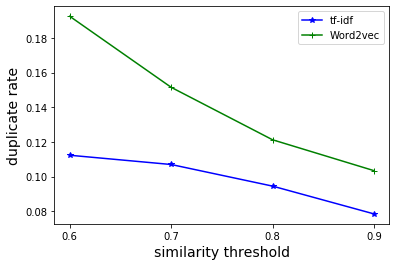

In [581]:
plt.xlabel('similarity threshold',fontsize=14)
plt.ylabel('duplicate rate',fontsize=14)
plt.plot(sim, tf_idf_rate,color="blue",marker="*",label="tf-idf")
plt.plot(sim, wordvec_rate,color="green",marker="+",label="Word2vec")
plt.xticks([x for x in sim]) 
plt.legend()
#plt.savefig('/Users/john/Desktop/rate_vs_sim.png',dpi = 500,bbox_inches ='tight')

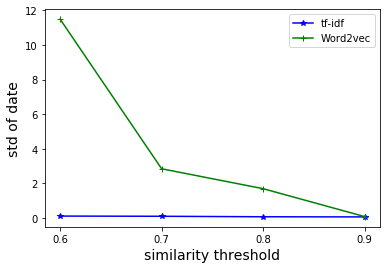

In [583]:
plt.xlabel('similarity threshold',fontsize=14)
plt.ylabel('std of date',fontsize=14)
plt.plot(sim, tf_idf_std_date,color="blue",marker="*",label="tf-idf")
plt.plot(sim, wordvec_std_date,color="green",marker="+",label="Word2vec")
plt.xticks([x for x in sim]) 
plt.legend()
#plt.savefig('/Users/john/Desktop/std_vs_sim.png',dpi = 500,bbox_inches ='tight')

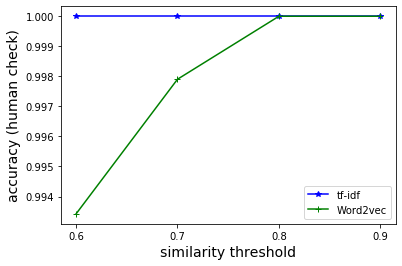

In [584]:
plt.xlabel('similarity threshold',fontsize=14)
plt.ylabel('accuracy (human check)',fontsize=14)
plt.plot(sim, tf_idf_human_check,color="blue",marker="*",label="tf-idf")
plt.plot(sim, wordvec_human_check,color="green",marker="+",label="Word2vec")
plt.xticks([x for x in sim]) 
plt.legend()
#plt.savefig('/Users/john/Desktop/accuracy_vs_sim.png',dpi = 500,bbox_inches ='tight')

Mini-Vocabulary Size:  33


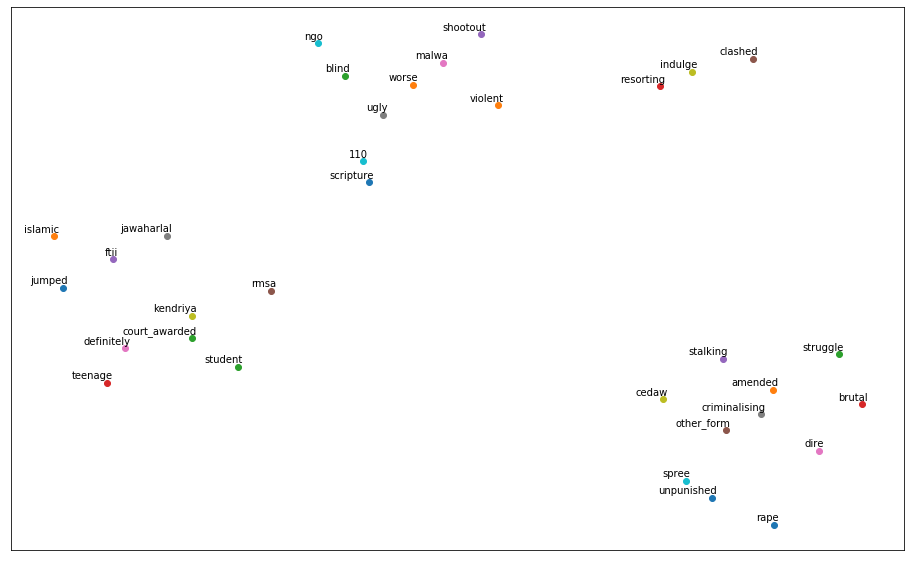

In [585]:
key_words = ['rape', 'violent', 'student']

words = [] # subset of vocabulary

for k in key_words:
    for i in range(len(model_word2vec.wv.most_similar(k))):
        words.append(model_word2vec.wv.most_similar(k)[i][0])
    words.append(k)        

print("Mini-Vocabulary Size: ", len(words))
 
# visualization by PCA+t-SNE

labels = [] # stores the words (labels)
tokens = [] # stores word vectors

for word in words:
    tokens.append(model_word2vec.wv.__getitem__(word))
    labels.append(word)
        
pca_tsne = Pipeline([
    ("pca", PCA(n_components=0.95, random_state=42)),
    ("tsne", TSNE(n_components=2, perplexity=3, random_state=42)), 
])

new_values = pca_tsne.fit_transform(tokens)

# get the two coordinates in two lists
x = []
y = []
for value in new_values:
    x.append(value[0])
    y.append(value[1])

plt.figure(figsize=(16, 10)) 
for i in range(len(x)):
    plt.scatter(x[i],y[i])
    plt.annotate(labels[i], 
                 xy=(x[i], y[i]),
                 xytext=(5, 2),   
                 textcoords='offset points', 
                 ha='right',
                 va='bottom') 
    
plt.xticks([])
plt.yticks([])
#plt.savefig('/Users/john/Desktop/semantic_relationship.png',dpi = 500,bbox_inches ='tight')
plt.show()